### Optimizating Drilling Speed (ROP) in Oil and Gas exploration wells
In the realm of oil and gas well drilling, expenses are significant, and the billing structure is predominantly time-based. Exploration companies are driven to reach the reservoir swiftly for well testing and conclusion. However, various operational and formation constraints impede the drilling speed, as indicated by the Rate of Penetration (ROP). ROP is a metric derived from the combination of the force applied to the drilling bit (weight) and the revolutions per minute (RPM) of the Top Drive System (TDS).

<p align="center">
  <img src="Images/Oil_Rig.jpeg" alt="Oil Rig">
</p>

Our approach involves predicting and optimizing ROP based on operational parameters and formation characteristics. These characteristics encompass permeability, porosity, and formation type. By strategically managing these factors, we aim to enhance ROP, enabling clients to achieve substantial cost savings in their drilling endeavors.

- <i>Author: <b>Sarmad Afzal</b></i>
- <i>Linkedin: https://www.linkedin.com/in/sarmadafzal/</i>
- <i>Github: https://github.com/sarmadafzalj</i>
- <i>Youtube: https://www.youtube.com/@sarmadafzalj</i>

In [116]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pyswarms as ps
from tqdm import tqdm



#### Dataset
Drilling data in real-time, sourced from an open platform, and Computed Petrophysical Output (CPO) log data are available for well number 15/9-F-15 located in the Volve Oil Field in the North Sea.

Here we have the column description:
- Depth: Drilling depth
- WOB: Weight on bit
- SURF_RPM: Rotation/min on surface
- <b>ROP_AVG</b>: Average rate of penetration
- PHIF: Formation porosity
- VSH: Shale volume
- SW: Water saturation
- KLOGH: Log permeability

In [117]:
df = pd.read_csv('Data/Data_for_ROP_optimization.csv')
df.head()

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
0,3305.0,26217.864,1.314720,0.004088,0.086711,0.071719,1.0,0.001
1,3310.0,83492.293,1.328674,0.005159,0.095208,0.116548,1.0,0.001
2,3315.0,97087.882,1.420116,0.005971,0.061636,0.104283,1.0,0.001
3,3320.0,54793.206,1.593931,0.005419,0.043498,0.110040,1.0,0.001
4,3325.0,50301.579,1.653262,0.005435,0.035252,0.120808,1.0,0.001


#### EDA
- We will plot the data to see the trend - Usually drilling data is visualize in logs format against depth
- We will find the statics of the data set
- We will understand the correlation between differnt features to understand relationships with ROP_AVG

In [118]:
#checking for null values
df.isnull().sum()

Depth       0
WOB         0
SURF_RPM    0
ROP_AVG     0
PHIF        0
VSH         0
SW          0
KLOGH       0
dtype: int64

In [119]:
#confirm correct data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Depth     151 non-null    float64
 1   WOB       151 non-null    float64
 2   SURF_RPM  151 non-null    float64
 3   ROP_AVG   151 non-null    float64
 4   PHIF      151 non-null    float64
 5   VSH       151 non-null    float64
 6   SW        151 non-null    float64
 7   KLOGH     151 non-null    float64
dtypes: float64(8)
memory usage: 9.6 KB


In [120]:
#lets visualize this data
logs = df.columns[1:]

fig = sp.make_subplots(rows=1, cols=len(logs), subplot_titles=logs)

for i, log_column in enumerate(logs, start=1):
    trace = go.Scatter(x=df[log_column], y=df['Depth'], mode='lines', name=log_column)
    fig.add_trace(trace, row=1, col=i)

fig.update_layout(title_text="Drilling Log", showlegend=False, height=800) 
fig.update_yaxes(autorange="reversed")

# Show the plot
fig.show()


In [121]:
#lets see the statistics of the data
df.describe()

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,3697.417219,45393.934391,2.034981,0.007800,0.084423,0.299809,0.975579,37.072228
std,227.169433,15784.246882,0.208492,0.001476,0.068230,0.264596,0.108946,127.186210
min,3305.000000,16961.916000,1.314720,0.002666,0.002968,0.049451,0.351393,-0.001124
25%,3502.500000,34320.946500,1.998711,0.007368,0.037550,0.108539,1.000000,0.001000
50%,3700.000000,44243.480000,1.999697,0.008157,0.059274,0.193100,1.000000,0.001000
75%,3887.500000,53212.685000,2.001069,0.008760,0.097212,0.387664,1.000000,0.001000
max,4085.000000,97087.882000,2.639233,0.010447,0.279346,1.000000,1.013335,709.158935


In [122]:
fig2 = sp.make_subplots(rows=3, cols=3, subplot_titles=logs)
for i, log_column in enumerate(logs, start=1):
    trace = go.Violin(x=df[log_column], name=log_column, box_visible=True, line_color='blue', fillcolor='lightseagreen')
    fig2.add_trace(trace, row=(i-1)//3 + 1, col=(i-1)%3 + 1)

fig2.update_layout(title_text="Distribution of Features", showlegend=False)


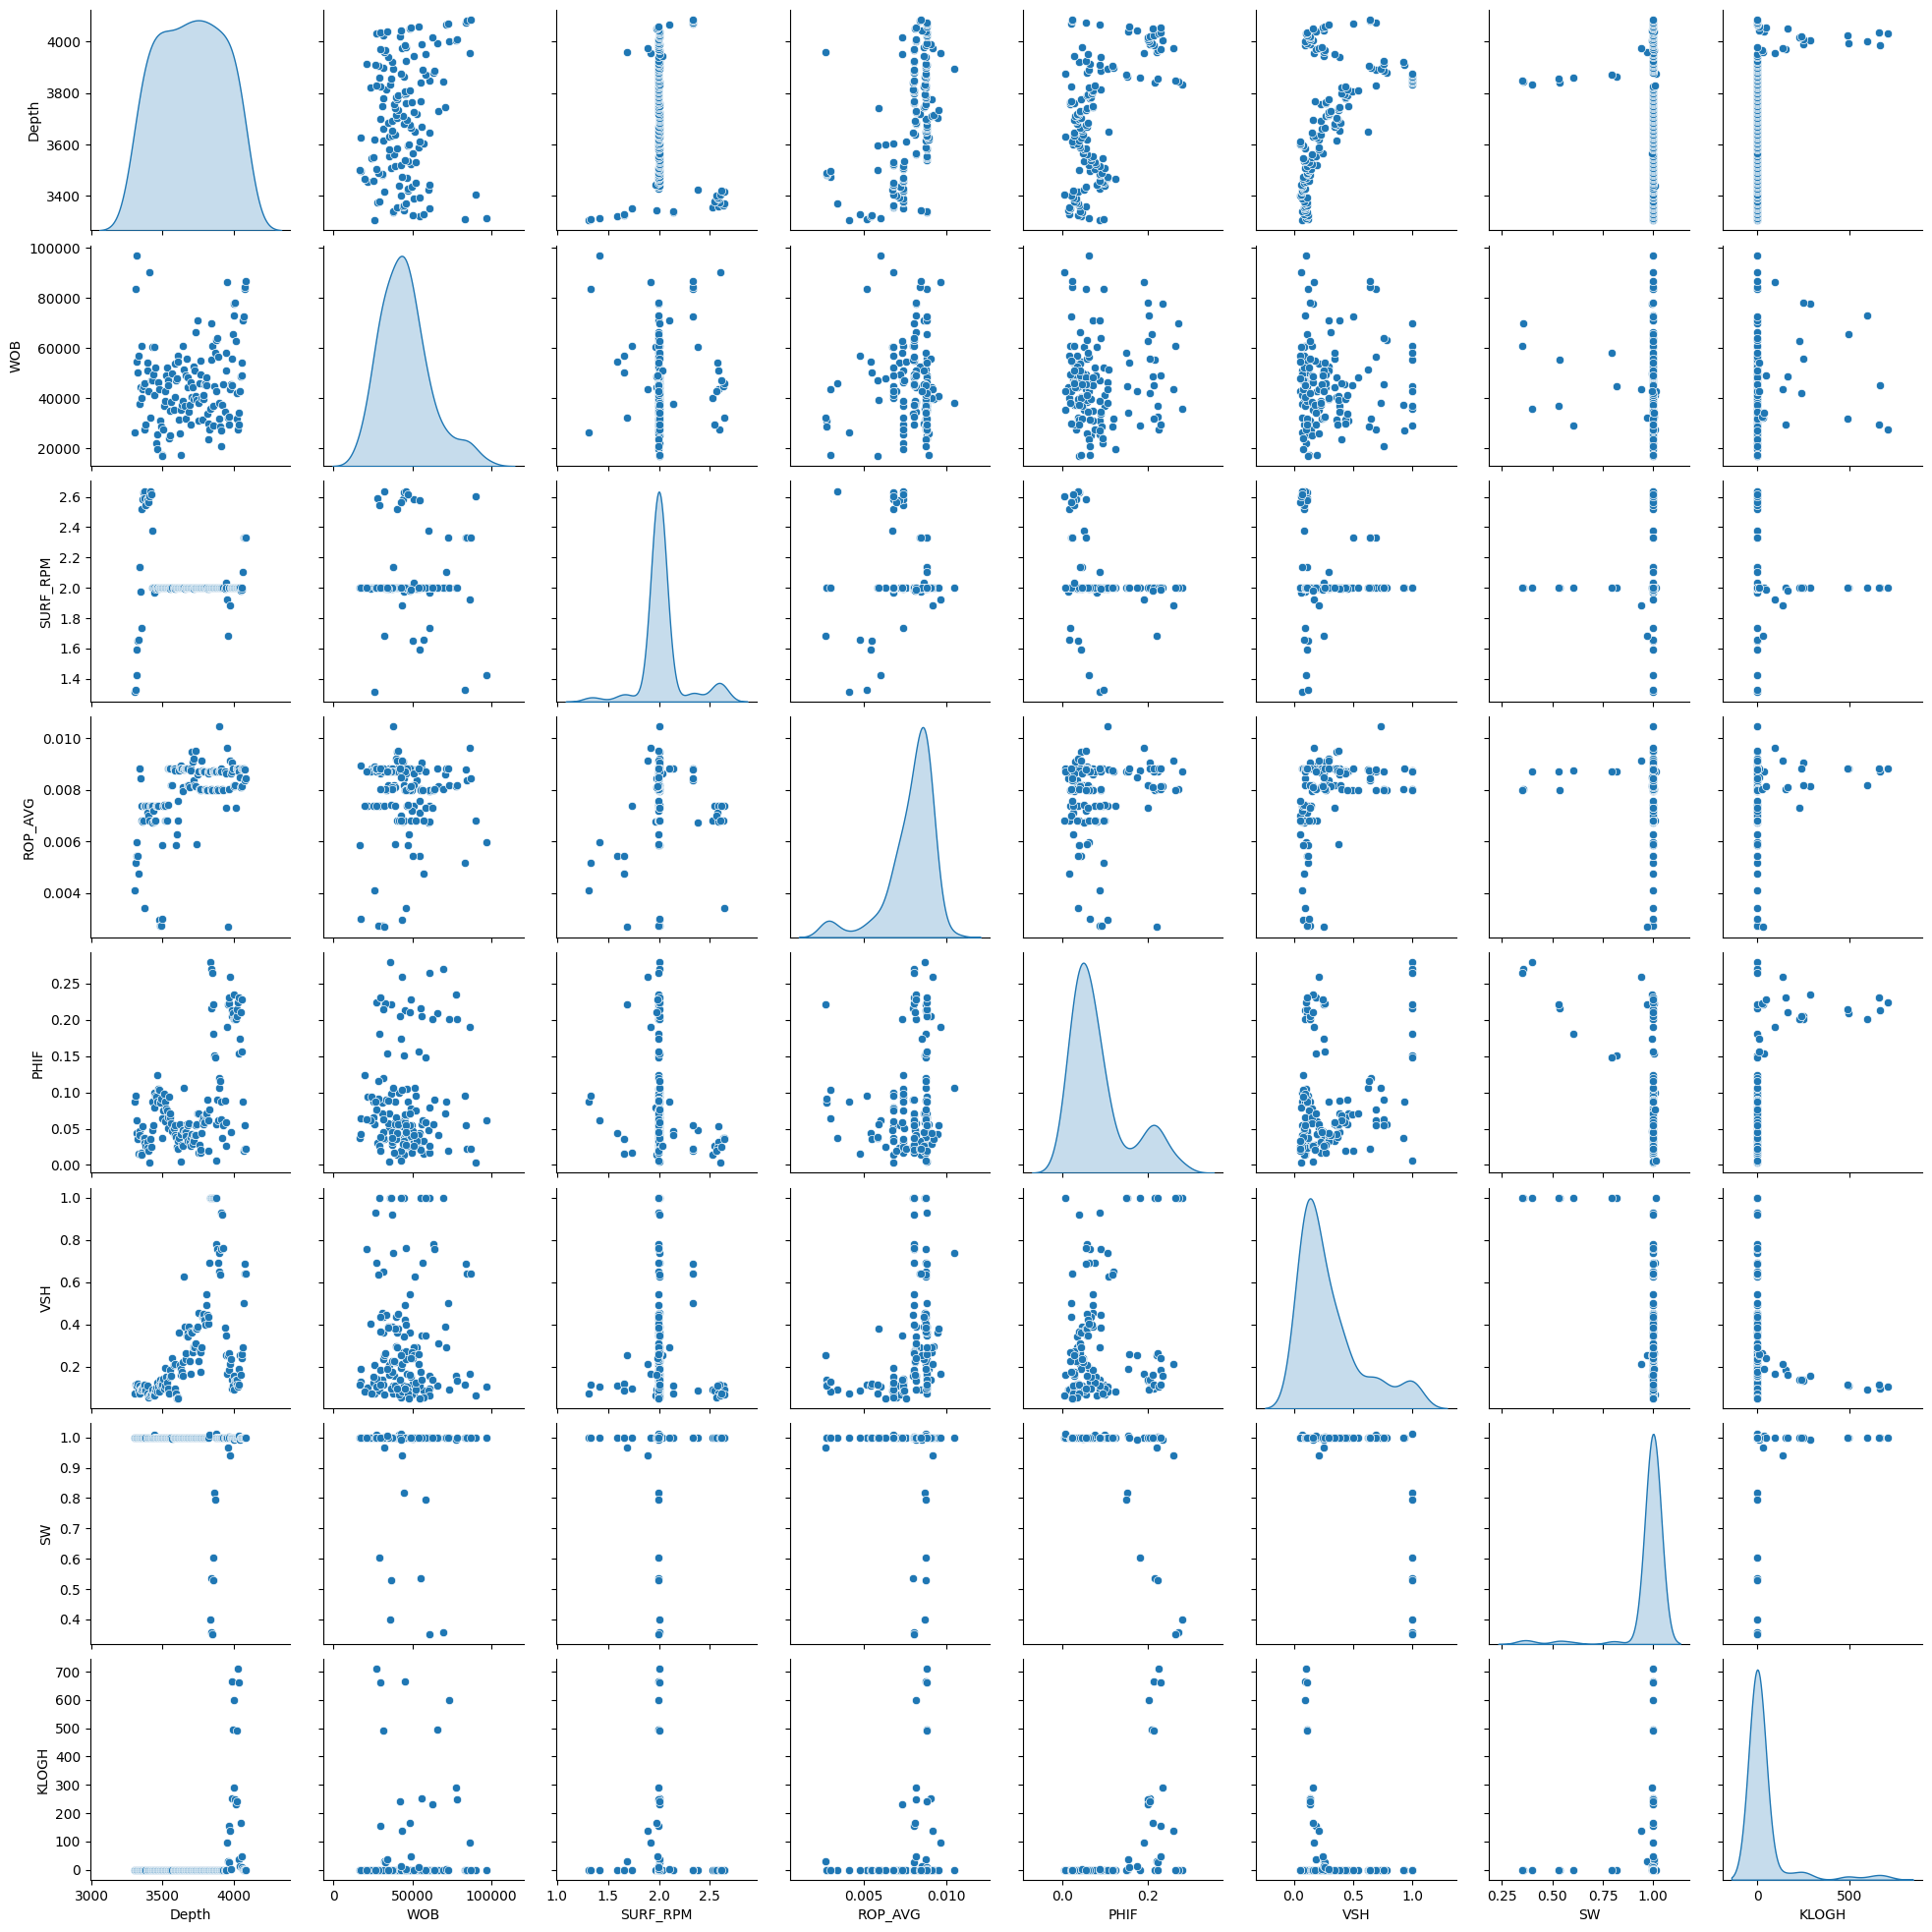

In [123]:
#lets see the pairplots
sns.pairplot(df, diag_kind='kde')

In [124]:
#lets see the correlations between features and ROP_AVG
df.corr()

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
Depth,1.000000,0.159770,-0.104547,0.499131,0.521520,0.508014,-0.154379,0.402978
WOB,0.159770,1.000000,0.007013,0.027432,0.033606,0.045963,-0.064150,0.070220
SURF_RPM,-0.104547,0.007013,1.000000,0.073833,-0.230075,-0.063986,0.043447,-0.058486
ROP_AVG,0.499131,0.027432,0.073833,1.000000,0.093381,0.349009,-0.080949,0.149617
PHIF,0.521520,0.033606,-0.230075,0.093381,1.000000,0.208022,-0.501702,0.561610
VSH,0.508014,0.045963,-0.063986,0.349009,0.208022,1.000000,-0.580621,-0.194376
SW,-0.154379,-0.064150,0.043447,-0.080949,-0.501702,-0.580621,1.000000,0.060306
KLOGH,0.402978,0.070220,-0.058486,0.149617,0.561610,-0.194376,0.060306,1.000000


In [125]:
fig = px.imshow(df.corr(), color_continuous_scale='Viridis', title='Correlation Plot')
fig.show()

📊 Looking at correlations, ROP is strong correlated with VSH (shale value) which is true, because in Shale we usually have slow ROPs, otherwise there is not strong correlation evident using the pearson method. 

📊 From the Violin distribution plot we can see that ROP_AVG is negatively skewed and hence we will have to do transformations to make it normal if we plan to use linear regression. We will try boosting models for this use case.

📊 From the drilling log, we can say that in the bottom 150ft of drilling there is a formation change, its no more shale, this caused all the plots to show divert and this argument is supported by permeability (KLOGH) and porosity (PHIF) as well. If the data points had GR signal it would have been much better.

📊 Around 3500ft we see a long drop in the ROP which could be due to many reasons. The driller is not using correct Weight on Bit and RPM to penetrate or there is higher formation pressure. Formation pressure value would have helped here but given the data we assume that we there is a need for optimzation to get best drilling performance.


<p align="center">
<image src="Images/Drilling_Bit1.png" with=200 height=200 align="center"/>           <image src="Images/Drilling_Bit2.png" with=200 height=200 align="center"/>
</p>

#### ML Modelling
- We will split data into X and Y(ROP_AVG) and then into train and test dataset with test data 20%
- Do data transformation
- Try a bunch of different Tree or bagging bossting models
- Evaluate against test dataset

##### Splitting

In [126]:
#splitting in X and y
X = df.drop(['ROP_AVG'], axis=1)
y = df['ROP_AVG']

#splitting in train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (120, 7)
X_test shape: (31, 7)
y_train shape: (120,)
y_test shape: (31,)


##### Transformation

In [127]:
#lets do some transfomations to the data
#we need not to do anything to encoding since this is all numerical data
#lets scale the data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pd.DataFrame(X_train_scaled)

,0,1,2,3,4,5,6
0,-1.412252,-0.982518,2.462856,-0.833196,-0.838254,0.253379,-0.271133
1,1.155479,-0.780094,-1.635079,1.967238,-0.232948,-0.011906,-0.031913
2,-1.500795,-0.018767,2.658937,-0.439695,-0.807275,0.253379,-0.271133
3,1.199750,-0.966851,-0.142176,2.102174,-0.492028,0.234639,0.987915
4,-0.526828,-0.591859,-0.137577,-0.492115,-0.402287,0.256643,-0.271133
...,...,...,...,...,...,...,...
115,-0.084115,0.034169,-0.131888,-0.737441,0.083118,0.253379,-0.271133
116,0.690631,-0.485084,-0.141442,1.977249,2.457038,-3.636150,-0.271133
117,-1.434388,-1.102554,2.689151,-0.775614,-0.744808,0.253379,-0.271133
118,0.380733,-0.284682,-0.140219,-0.268099,0.420551,0.253379,-0.271133


Now the data is scaled with StandardScaler and here are some benefits:
- Data is now more comparable since it is standardized with mean = 0
- We have data in multiple units, not they are ready to contribute equally in the ML model

##### Modelling

In [128]:
#lets fit XGBoost model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

#lets predict on test data
y_pred = xgb.predict(X_test_scaled)


In [129]:
#lets see the metrics
print(f"Mean of ROP_AVG: {df['ROP_AVG'].mean()}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R2: {r2_score(y_test, y_pred)}")


Mean of ROP_AVG: 0.007799966029139062
RMSE: 0.0011222045053097933
R2: 0.3163315078830393


From this attemp, it is clear that the results are not very good and we need to do some hyperparameter tuning

##### Hyperparameter Tuning

In [130]:
#hyperparameter tuning
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}

grid = GridSearchCV(estimator=xgb, param_grid=params, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

#lets predict on test data
y_pred = grid.predict(X_test_scaled)

#lets see the metrics
print(f"Mean of ROP_AVG: {df['ROP_AVG'].mean()}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R2: {r2_score(y_test, y_pred)}")



Fitting 5 folds for each of 125 candidates, totalling 625 fits


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best score: 0.34291428566647336
Mean of ROP_AVG: 0.007799966029139062
RMSE: 0.0008927324754098115
R2: 0.5673425197780438


Now we you can see that we have much better results from the previous iteration

##### Predictions

In [131]:
#lets take a prediction at 3481 ft where previously the ROP dropped.
#we will keep the other features constant at 3480 ft

test_rop = df[df.Depth==3480]
test_rop

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
33,3480.0,31236.811,1.999362,0.00271,0.086571,0.139695,1.0,0.001


Lets define our prediction function so that we can always use it later on

In [132]:
#prediction function
def predict_rop(model, data):
    if 'ROP_AVG' in data.columns:
        data = data.drop(['ROP_AVG'], axis=1)
    data_scaled = scaler.transform(data)
    prediction = model.predict(data_scaled)
    return prediction

In [133]:
print("Predicted ROP", predict_rop(grid, test_rop)[0])
print("Actual ROP", test_rop['ROP_AVG'].values[0])

Predicted ROP 0.0043714903
Actual ROP 0.0027096241


Our model predicted that the value of ROP should have been 0.0043 whereas it was 0.0027 has some of its parameters were not optmitized correctly so lets optimize it

#### Optimization
We will use PSO (Particle Swarm Optimization) technique to find the optimal values of the Weight on Bit and Surface RPM while the rest of the features would remain constant.

- Range of WOB: 10K N to 100KN
- Range of RPM: 1.2 to 2.8 rpm
- Constants: 
    - Depth: 3480
    - PHIF: 0.086571			
    - VSH: 0.139695
    - SW: 1.0
    - KLOGH: 0.001

In [134]:
#lets define range of WOB and RPM
WOB = np.linspace(15000, 100000, 50)
RPM = np.linspace(1.2, 2.8, 50)

#lets define the constants
constants = {'Depth': 3480, 'PHIF': 0.086571, 'VSH': 0.139695, 
                   'SW': 1, 'KLOGH': 0.001}     

#lets define the space
def space(model, WOB, RPM, constants):
    total_iterations = len(WOB) * len(RPM)
    space_matrix = np.empty((len(WOB), len(RPM)))
    with tqdm(total=total_iterations, desc="Overall Progress") as pbar:

        for i in range(len(WOB)):
            for j in range(len(RPM)):
                data = pd.DataFrame({'Depth':constants['Depth'], 'WOB': WOB[i], 'SURF_RPM': RPM[j], 'PHIF': constants['PHIF'], 'VSH': constants['VSH'], 
                    'SW': constants['SW'], 'KLOGH': constants['KLOGH']}, index=[0])
                space_matrix[i, j] = predict_rop(model, data)
                #print(f"Completed: {i*len(RPM) + j + 1}/{len(WOB)*len(RPM)}")
                #print(space_matrix[i, j])
                pbar.update(1)
        fig = go.Figure(data=go.Heatmap(z=space_matrix, x=RPM, y=WOB, colorscale='inferno'))

        # Set axis labels and title
        fig.update_layout(
            xaxis_title='RPM',
            yaxis_title='WOB',
            title='ROP_AVG'
        )

        # Show the plot
        fig.show()


In [135]:
space(grid, WOB, RPM, constants)

Overall Progress:   5%|▌         | 128/2500 [00:00<00:12, 188.32it/s]

Overall Progress:  99%|█████████▉| 2482/2500 [00:10<00:00, 253.82it/s]

Overall Progress: 100%|██████████| 2500/2500 [00:10<00:00, 235.84it/s]


very clearly from the graph we can conclude that his actual RPM was 2 but he WOB was around 31KN. Where as we can see if he would have increaed the WOB around 35-40 KN he would have gotten much better ROP

Lets run the optimization to see what are the optimal values of **SURF_RPM** and **WOB**

In [139]:
from pyswarm import pso

#lets define the objective function
def objective_function(params, model, constants):
    WOB, RPM = params
    data = pd.DataFrame({'Depth': constants['Depth'], 'WOB': WOB, 'SURF_RPM': RPM,
                         'PHIF': constants['PHIF'], 'VSH': constants['VSH'],
                         'SW': constants['SW'], 'KLOGH': constants['KLOGH']}, index=[0])
    predicted_rop = predict_rop(model, data)
    return -predicted_rop  
    #you see that we have a negative sign in front of predicted_rop. This is because we want to maximize the predicted rop.
    

# Define the search space bounds for PSO
lb = [15000, 1.2]  # Lower bounds for WOB and RPM
ub = [100000, 2.8]  # Upper bounds for WOB and RPM

best_params, _ = pso(objective_function, lb, ub, args=(grid, constants))
optimized_WOB, optimized_RPM = best_params

print(f"Optimized WOB: {optimized_WOB}")
print(f"Optimized RPM: {optimized_RPM}")

Stopping search: maximum iterations reached --> 100
Optimized WOB: 61078.346066389626
Optimized RPM: 2.40480463719757


Overall Progress: 100%|█████████▉| 2498/2500 [00:11<00:00, 212.37it/s]

Overall Progress: 100%|██████████| 2500/2500 [00:11<00:00, 221.00it/s]


By Looking at the best parametered from PSO, we now have the most optimal values for WOB and RPM. He should have slighted increased the RPMs which was 2 previously to 2.4 and should have increased WOB much more as the suggested value 61KN is twice what he previously had.

#### Exporting the Model for inference app

In [143]:
import pickle
with open('Azure_Function/grid_model.pkl', 'wb') as file:
    pickle.dump(grid, file)

with open('Azure_Function/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)